# Import libraries

In [403]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

from scipy.stats import norm, skew #for some statistics
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox

import warnings 

from utils import pivot_table_plot

warnings.filterwarnings(action = 'ignore')

pd.options.display.float_format = '{:,.0f}'.format

# Import data

In [327]:
df = pd.read_csv('data/Processed_data_for_EDA.csv', index_col='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2582 entries, 1 to 2667
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           2582 non-null   float64
 1   listing_title   2582 non-null   object 
 2   sqft            2582 non-null   float64
 3   bedrooms        2582 non-null   float64
 4   bathrooms       2582 non-null   float64
 5   address         2582 non-null   object 
 6   price_per_sqft  2582 non-null   float64
 7   listing_tags    2582 non-null   object 
 8   tenure          2582 non-null   object 
 9   floor_size_det  2582 non-null   float64
 10  url             2582 non-null   object 
 11  state           2582 non-null   object 
 12  district        2582 non-null   object 
 13  pool            2582 non-null   bool   
 14  fitness         2582 non-null   bool   
 15  balcony         2582 non-null   bool   
dtypes: bool(3), float64(6), object(7)
memory usage: 290.0+ KB


# EDA

## Univariate Analysis

### Target Variable

Explore the distribution of price in the dataset.

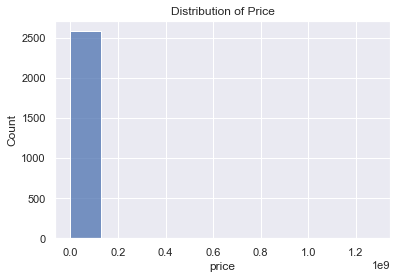

In [328]:
sns.histplot(data = df, x = 'price', bins = 10)
plt.title('Distribution of Price');

We can see that a lot of the price clusters around 0 to 200,000,000 (RM 200 mil). Suspect that there a lot of outliers as there are some property prices that are more than RM 200 mil.


 mu = 1494602.60 and sigma = 25189241.69



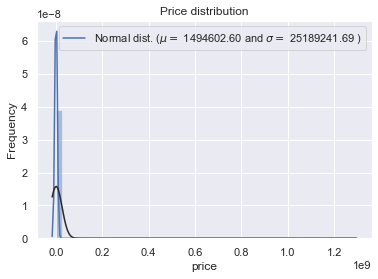

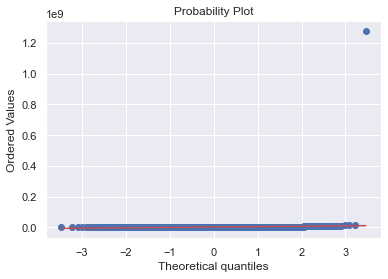

In [329]:
sns.distplot(df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

We can see that the distribution of price is highly right-skewed. 

In [330]:
df['price'].describe()

count           2,582
mean        1,494,603
std        25,194,121
min             1,500
25%           418,000
50%           650,000
75%         1,150,000
max     1,280,000,000
Name: price, dtype: float64

We can see that there might be an outlier with extremely high house price as the maximum property price is RM 1.28 billion. But we still have to inspect whether it is really an outlier.

In [331]:
df.sort_values(by = 'price', ascending = False).head(5)

,price,listing_title,sqft,bedrooms,bathrooms,address,price_per_sqft,listing_tags,tenure,floor_size_det,url,state,district,pool,fitness,balcony
id,,,,,,,,,,,,,,,,
1692,"1,280,000,000",Lakeside SemiD @ FERRHOLD,"2,407",4,4,"Puchong South, Puchong, Selangor","531,782",Semi-Detached House,Freehold,"2,407",https://www.propertyguru.com.my/property-listi...,Selangor,Puchong,False,False,False
1287,"12,000,000",Kemensah Heights,"17,000",8,8,"Jalan Tiga (3), Ampang Jaya, Ampang, Selangor",706,Bungalow House,Freehold,"10,080",https://www.propertyguru.com.my/property-listi...,Selangor,Ampang,False,False,False
1348,"12,000,000",Kemensah Heights,"17,000",8,8,"Jalan Tiga (3), Ampang Jaya, Ampang, Selangor",706,Bungalow House,Freehold,"10,080",https://www.propertyguru.com.my/property-listi...,Selangor,Ampang,False,False,False
565,"11,500,000",Country Heights Kajang,"20,000",9,9,"Unnamed Road, Country Heights, Kajang, Selangor",575,Bungalow House,Freehold,"14,000",https://www.propertyguru.com.my/property-listi...,Selangor,Kajang,False,False,True
1141,"10,900,000",Country Heights Kajang,"20,000",7,9,"Unnamed Road, Country Heights, Kajang, Selangor",545,Bungalow House,Freehold,"16,500",https://www.propertyguru.com.my/property-listi...,Selangor,Kajang,True,False,True


We can see that the two listings are clearly outliers. 

We can assume that the listings are wrong.

In [332]:
drop_rows = df[df.price > 1_000_000_000].index.tolist()

df = df.drop(drop_rows)

In [333]:
df['price'].describe()

count        2,581
mean       999,250
std      1,089,806
min          1,500
25%        418,000
50%        650,000
75%      1,150,000
max     12,000,000
Name: price, dtype: float64

we can see that there are property with price just around RM 4k, which is rediculous. This might due to the property was to be rented instead of selling it or even typo from the property agent.

In [334]:
df.sort_values(by = 'price', ascending = True).head(5)

,price,listing_title,sqft,bedrooms,bathrooms,address,price_per_sqft,listing_tags,tenure,floor_size_det,url,state,district,pool,fitness,balcony
id,,,,,,,,,,,,,,,,
1309,"1,500",Aera Residence,718,2,1,"Jalan PJS 5/28 Kampung Ghandi, Petaling Jaya, ...",2,Service Residence,Leasehold,718,https://www.propertyguru.com.my/property-listi...,Selangor,Petaling Jaya,True,True,False
155,"88,000",RM88K 2R2B Freehold 【Free 2 Year Maintanence +...,889,2,2,"Cyberjaya, Selangor",99,Condominium,Freehold,889,https://www.propertyguru.com.my/property-listi...,Selangor,Cyberjaya,False,False,False
2611,"95,000",damansara damai,650,3,2,"Sungai Buloh, Selangor",146,Apartment,Freehold,650,https://www.propertyguru.com.my/property-listi...,Selangor,Sungai Buloh,False,False,False
1623,"95,000",Apartment Harmoni,650,3,2,"Damansara Damai, Damansara, Selangor",146,Apartment,Leasehold,650,https://www.propertyguru.com.my/property-listi...,Selangor,Damansara,False,False,False
2531,"95,000",damansara damai,650,3,2,"Sungai Buloh, Selangor",146,Apartment,Freehold,650,https://www.propertyguru.com.my/property-listi...,Selangor,Sungai Buloh,False,False,False


In [335]:
drop_rows = df[df.price < 10000].index.tolist()

df = df.drop(drop_rows)

In [336]:
df['price'].describe()

count        2,580
mean       999,637
std      1,089,840
min         88,000
25%        418,000
50%        650,000
75%      1,150,000
max     12,000,000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

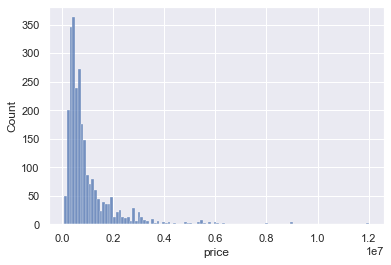

In [337]:
sns.histplot(df['price'])

We can see that the price's distribution is still highly skewed. We can apply log transformation to make it more normal.

In [338]:
df['log_price'] = np.log1p(df['price'])

<AxesSubplot:xlabel='log_price', ylabel='Count'>

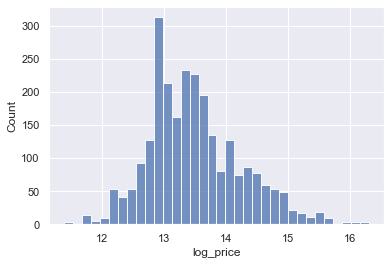

In [339]:
sns.histplot(df['log_price'])


 mu = 13.49 and sigma = 0.75



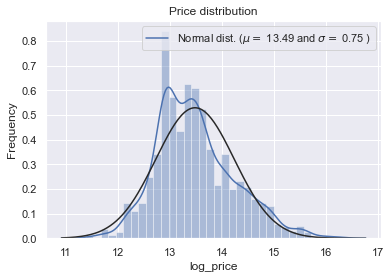

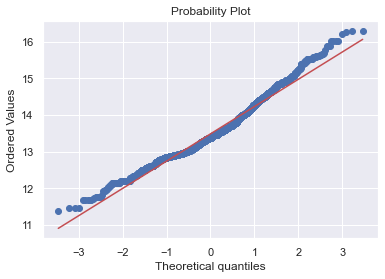

In [340]:
sns.distplot(df['log_price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['log_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['log_price'], plot=plt)
plt.show()

We can see that the distribution of log(price) seems follow a normal distribution than before but apparently there are still outliers.

## Multivariate Analysis
### Let's see which features are highly correlated (positive or negative) with the target features.

<AxesSubplot:>

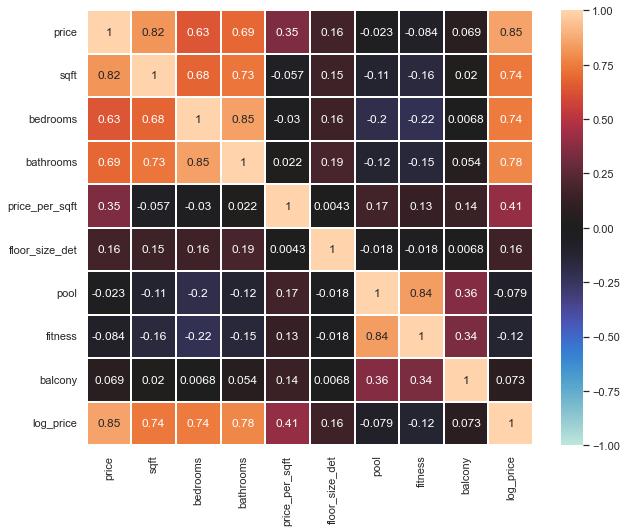

In [341]:
fig, ax = plt.subplots(figsize = (10,8))

sns.heatmap(df.corr(), annot=True, linewidths=2, center=0, vmax=1, vmin = -1)

### Does squared feet of the property affects the property's price?

<AxesSubplot:xlabel='sqft', ylabel='price'>

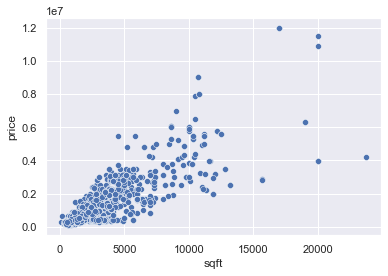

In [342]:
sns.scatterplot(data = df, x = 'sqft',y = 'price')

We can see that there is a few listings with extremely high sqft but lower price than the listings with smaller sqft.

In [343]:
df.loc[df.sqft > 15000].sort_values(by = 'sqft')

,price,listing_title,sqft,bedrooms,bathrooms,address,price_per_sqft,listing_tags,tenure,floor_size_det,url,state,district,pool,fitness,balcony,log_price
id,,,,,,,,,,,,,,,,,
551,"2,880,000",Bandar Bukit Mahkota Bangi,"15,683",6,6,"Bunglow, Bandar Baru Bangi, Bangi, Selangor",184,Bungalow House,Freehold,"8,566",https://www.propertyguru.com.my/property-listi...,Selangor,Bangi,False,False,True,15
1554,"2,800,000","Fully Furnished Bungalow Bandar Bukit Mahkota,...","15,683",5,6,"Bangi, Selangor",179,Bungalow House,Freehold,"8,566",https://www.propertyguru.com.my/property-listi...,Selangor,Bangi,False,False,False,15
1287,"12,000,000",Kemensah Heights,"17,000",8,8,"Jalan Tiga (3), Ampang Jaya, Ampang, Selangor",706,Bungalow House,Freehold,"10,080",https://www.propertyguru.com.my/property-listi...,Selangor,Ampang,False,False,False,16
1348,"12,000,000",Kemensah Heights,"17,000",8,8,"Jalan Tiga (3), Ampang Jaya, Ampang, Selangor",706,Bungalow House,Freehold,"10,080",https://www.propertyguru.com.my/property-listi...,Selangor,Ampang,False,False,False,16
95,"6,300,000","Bukit Gasing, Gasing Hill, Petaling Jaya","19,002",6,6,"Petaling Jaya, Selangor",332,Bungalow House,Leasehold,"6,000",https://www.propertyguru.com.my/property-listi...,Selangor,Petaling Jaya,False,False,False,16
922,"6,300,000","Bukit Gasing, Gasing Hill, Petaling Jaya","19,002",6,6,"Petaling Jaya, Selangor",332,Bungalow House,Leasehold,"6,000",https://www.propertyguru.com.my/property-listi...,Selangor,Petaling Jaya,False,False,False,16
287,"3,980,000",Country Heights Kajang,"20,000",8,7,"Unnamed Road, Country Heights, Kajang, Selangor",199,Bungalow House,Freehold,"10,000",https://www.propertyguru.com.my/property-listi...,Selangor,Kajang,False,False,False,15
565,"11,500,000",Country Heights Kajang,"20,000",9,9,"Unnamed Road, Country Heights, Kajang, Selangor",575,Bungalow House,Freehold,"14,000",https://www.propertyguru.com.my/property-listi...,Selangor,Kajang,False,False,True,16
989,"3,980,000",Country Heights Kajang,"20,000",8,7,"Unnamed Road, Country Heights, Kajang, Selangor",199,Bungalow House,Freehold,"10,000",https://www.propertyguru.com.my/property-listi...,Selangor,Kajang,False,False,False,15


We can see that the listing with the lowest price is clearly wrong as the range between the lowest 2 and the subsequents listings is extremely big.

In [344]:
drop_rows = df.loc[df.sqft > 15000].index.tolist()

df = df.drop(drop_rows)

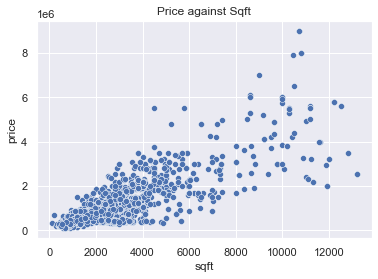

In [345]:
sns.scatterplot(data = df, x = 'sqft',y = 'price')
plt.title('Price against Sqft');

In [346]:
# let's work on the column floor_size_det

In [347]:
df.loc[df.sqft != df.floor_size_det][['sqft','floor_size_det']]

,sqft,floor_size_det
id,,
13,"3,900","3,899"
23,"8,740","7,401"
32,"10,300","7,800"
40,"6,000","5,600"
42,"5,550","3,890"
...,...,...
2616,"4,000","3,051"
2619,"6,000","3,000"
2644,"5,000","2,700"


We can see that there are around 212 rows out of 2500+ rows where the 2 columns does not match

In [348]:
df_sqft = df[['price','sqft','floor_size_det','price_per_sqft']].copy()

df_sqft['diff'] = df['sqft'] - df['floor_size_det']

<AxesSubplot:xlabel='diff', ylabel='Count'>

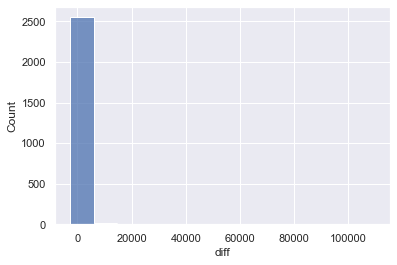

In [349]:
sns.histplot(df_sqft['diff'])

In [350]:
df_sqft[df_sqft['diff'] > 20000]

,price,sqft,floor_size_det,price_per_sqft,diff
id,,,,,
474,"2,999,000","9,785","-99,999",306,"109,784"
884,"2,990,000","9,785","-99,999",306,"109,784"
1016,"1,395,000","6,445","-99,999",216,"106,444"
1057,"2,780,000","6,790","-99,999",409,"106,789"
1414,"1,580,000","6,400","-99,999",247,"106,399"
1650,"5,220,000","9,181","-99,999",569,"109,180"


<AxesSubplot:xlabel='diff', ylabel='Count'>

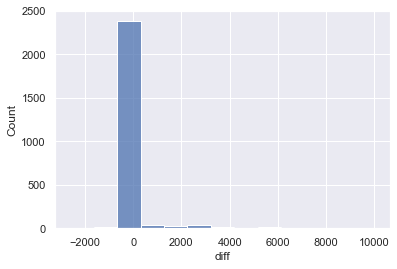

In [351]:
sns.histplot(df_sqft[df_sqft['diff'] <= 20000]['diff'])

In [352]:
# Verify whether price divide by sqft = price_per_sqft

df_sqft['price/sqft'] = df.price / df.sqft
df_sqft.loc[df_sqft['price/sqft'] != df_sqft['price_per_sqft']]

,price,sqft,floor_size_det,price_per_sqft,diff,price/sqft
id,,,,,,
1,"1,288,000","2,622","2,622",491,0,491
2,"1,600,000","1,847","1,847",866,0,866
3,"400,000","1,100","1,100",364,0,364
4,"665,000","1,535","1,535",433,0,433
5,"599,000","1,900","1,900",315,0,315
...,...,...,...,...,...,...
2663,"1,250,000","3,800","3,800",329,0,329
2664,"980,000","2,750","2,750",356,0,356
2665,"880,000","1,084","1,084",812,0,812


<AxesSubplot:xlabel='price_sqft_diff', ylabel='Count'>

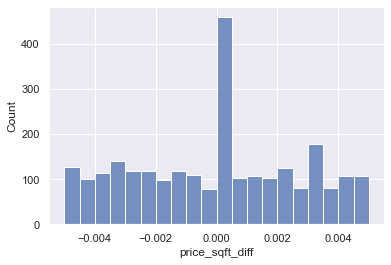

In [353]:
df_sqft['price_sqft_diff'] = df_sqft['price/sqft'] - df_sqft['price_per_sqft']
sns.histplot(df_sqft['price_sqft_diff'], bins = 20)

In [354]:
df_sqft.describe()

,price,sqft,floor_size_det,price_per_sqft,diff,price/sqft,price_sqft_diff
count,"2,569","2,569","2,569","2,569","2,569","2,569","2,569"
mean,"974,006","2,494","2,068",399,425,399,-0
std,"990,661","1,979","5,158",187,"5,291",187,0
min,"88,000",120,"-99,999",68,"-2,600",68,-0
25%,"418,000","1,215","1,209",292,0,292,-0
50%,"650,000","1,996","1,966",375,0,375,0
75%,"1,100,000","3,000","3,000",491,0,491,0
max,"9,000,000","13,185","12,200","3,750","109,784","3,750",0


We can see that actually the difference between the price/sqft and price per sqft columns are really minimal, which is mainly due to decimals differences. Therefore, we can drop the price_sqft_diff columns as it carries the same information and might cause data leakage during modelling stage.

Since dividing the price by sqft will get values which are almost identical to the price_per_sqft column, this actually can conclude that the values in 'sqft' feature is accuracy. Therefore, we can drop the floor_size_det feature as it noy only carries the similar values as 'sqft' but it even contains a lot of wrong values in it.

In [355]:
to_drop = ['floor_size_det','price_per_sqft']

for col in to_drop:
    if col in df.columns:
        df.drop(columns = col, inplace = True)
    else:
        pass
    

In [356]:
df.describe()

,price,sqft,bedrooms,bathrooms,log_price
count,"2,569","2,569","2,569","2,569","2,569"
mean,"974,006","2,494",4,4,13
std,"990,661","1,979",1,2,1
min,"88,000",120,0,0,11
25%,"418,000","1,215",3,2,13
50%,"650,000","1,996",4,3,13
75%,"1,100,000","3,000",5,4,14
max,"9,000,000","13,185",10,9,16


It's look like the value is quite normal, maybe we can look at the distribution of sqft

<AxesSubplot:xlabel='sqft', ylabel='Count'>

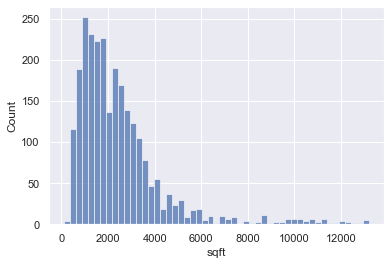

In [357]:
sns.histplot(df['sqft'])

Okay, the sqft column is heavily skewed as well.

In [358]:
print(f"Skewness of sqft columns: {round(skew(df['sqft']),2)}")

Skewness of sqft columns: 2.5


A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

Source: https://docs.oracle.com/cd/E57185_01/CBREG/ch03s02s03s01.html

In [359]:
df['sqft_boxcox'], lam_hat = boxcox(df['sqft'])

In [360]:
lam_hat

-0.054377581982923306

In [361]:
skew(df['sqft_boxcox'])

-0.0011823566832872103

In [362]:
df.head()

,price,listing_title,sqft,bedrooms,bathrooms,address,listing_tags,tenure,url,state,district,pool,fitness,balcony,log_price,sqft_boxcox
id,,,,,,,,,,,,,,,,
1,"1,288,000",ECO SANCTUARY,"2,622",5,5,"Lot 41296 Persiaran Eco Sanctuary, Telok Pangl...",2-storey Terraced House,Leasehold,https://www.propertyguru.com.my/property-listi...,Selangor,Kuala Langat,True,True,True,14,6
2,"1,600,000",Kinrara Residence - 3 Storey Link House,"1,847",5,5,"Jalan DU 4/7, Puchong, Selangor",3-storey Terraced House,Leasehold,https://www.propertyguru.com.my/property-listi...,Selangor,Puchong,True,False,True,14,6
3,"400,000",Menara Mutiara,"1,100",3,2,"Jalan 11 Off Jalan 1, Taman TAR, Ampang Jaya, ...",Condominium,Leasehold,https://www.propertyguru.com.my/property-listi...,Selangor,Ampang,False,False,True,13,6
4,"665,000","Ellis, Bandar Bukit Raja","1,535",4,3,"Jalan Sumazau 3/KU5, Bandar Bukit Raja, Klang,...",2-storey Terraced House,Freehold,https://www.propertyguru.com.my/property-listi...,Selangor,Klang,False,False,False,13,6
5,"599,000",Seri Bangi Seksyen 8 Bandar Baru Bangi,"1,900",4,3,"Jalan 8/35, Bandar Baru Bangi, Bangi, Selangor",2-storey Terraced House,Leasehold,https://www.propertyguru.com.my/property-listi...,Selangor,Bangi,True,False,False,13,6


After transforming and preprocessed all the numeric features, we can move on to explore the categorical features in our dataset and how the target variable was affected by it.

### What is the majority number of bedrooms in the Selangor's listing

In [363]:
df['bedrooms'].value_counts().sort_index()

0       16
1       27
2      167
3      498
4     1135
5      417
6      216
7       70
8       19
9        3
10       1
Name: bedrooms, dtype: int64

We can see that most of the property contains 4 bedrooms, and in fact, most of the property contains 3 or more bedrooms.

In [364]:
df.groupby('bedrooms')['price'].agg(['mean','min','max'])

,mean,min,max
bedrooms,,,
0,"315,518","198,600","650,000"
1,"377,056","200,000","697,000"
2,"335,240","88,000","772,668"
3,"451,846","95,000","2,405,800"
4,"723,052","203,400","2,800,000"
5,"1,433,337","329,000","7,980,000"
6,"2,284,261","421,000","9,000,000"
7,"2,874,827","620,000","6,100,000"
8,"4,020,789","1,400,000","7,000,000"


It was clearly shown that the averge house price increases as num of bedrooms increases. Maybe we can see the number of bedrooms for different type of property.

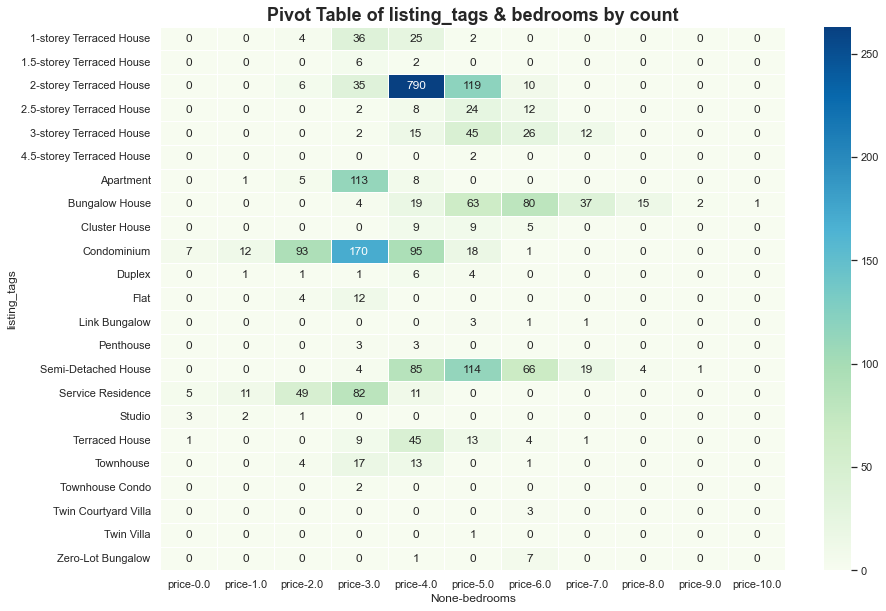

In [366]:
pivot_table_plot('listing_tags','bedrooms')

We can see that mainly are bungalow house & Semi-D property that have more number of bedrooms.

### Will number of bathrooms affect the property's price?

In [367]:
df['bathrooms'].value_counts().sort_index()

0      1
1    112
2    620
3    719
4    541
5    282
6    158
7    100
8     26
9     10
Name: bathrooms, dtype: int64

In [368]:
df.groupby('bathrooms')['price'].agg(['mean','median','min','max']).round(2)

,mean,median,min,max
bathrooms,,,,
0,"650,000","650,000","650,000","650,000"
1,"281,507","270,000","118,000","638,000"
2,"425,916","400,000","88,000","1,470,000"
3,"714,871","670,000","203,400","2,500,000"
4,"828,729","652,000","300,000","3,850,000"
5,"1,592,257","1,394,000","329,000","7,980,000"
6,"2,069,730","1,900,000","421,000","7,900,000"
7,"3,257,645","2,825,000","620,000","9,000,000"
8,"4,168,185","4,800,000","1,500,000","6,000,000"


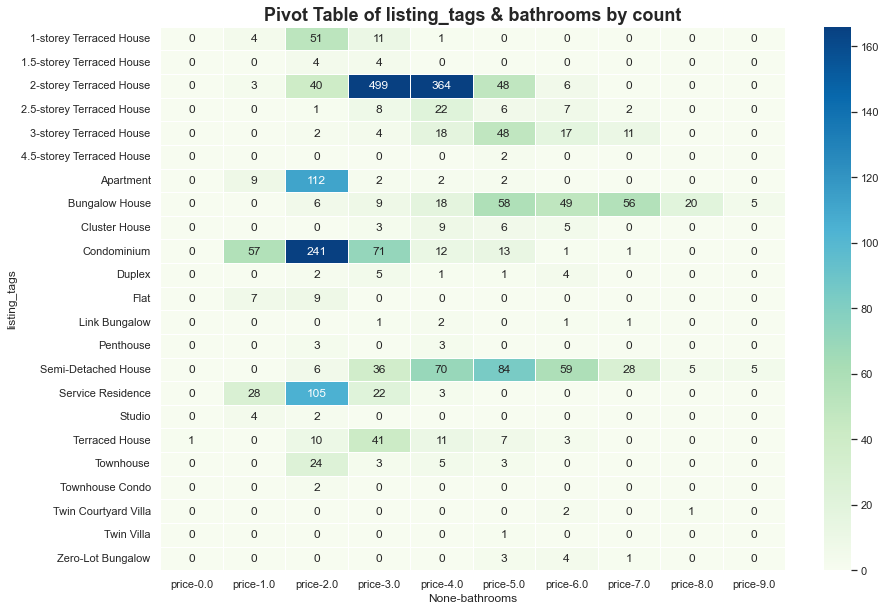

In [369]:
pivot_table_plot('listing_tags','bathrooms')

### Will landed or high-rise property affects the property price?

In [370]:
df['listing_tags'].value_counts()

2-storey Terraced House      960
Condominium                  396
Semi-Detached House          293
Bungalow House               221
Service Residence            158
Apartment                    127
3-storey Terraced House      100
Terraced House                73
1-storey Terraced House       67
2.5-storey Terraced House     46
Townhouse                     35
Cluster House                 23
Flat                          16
Duplex                        13
Zero-Lot Bungalow              8
1.5-storey Terraced House      8
Studio                         6
Penthouse                      6
Link Bungalow                  5
Twin Courtyard Villa           3
Townhouse Condo                2
4.5-storey Terraced House      2
Twin Villa                     1
Name: listing_tags, dtype: int64

It seems like there are too many different type of property available in the dataset. Maybe we can reassign some of the property types to new classes.

In [371]:
# group it to high-rise or landed.
# group it to a fewer class which is more representative.

landed_words = ['house','bungalow','villa']

prop_type_mapper = {}

for cat in df['listing_tags'].unique().tolist():
    for val in landed_words:
        if val in cat.lower():
            prop_type_mapper[cat] = 'landed'
            break
        else:
            prop_type_mapper[cat] = 'high-rise'

prop_type_mapper['Penthouse'] = 'high-rise'
prop_type_mapper

{'2-storey Terraced House': 'landed',
 '3-storey Terraced House': 'landed',
 'Condominium': 'high-rise',
 '1-storey Terraced House': 'landed',
 'Apartment': 'high-rise',
 'Bungalow House': 'landed',
 'Service Residence': 'high-rise',
 'Semi-Detached House': 'landed',
 '2.5-storey Terraced House': 'landed',
 'Terraced House': 'landed',
 'Townhouse': 'landed',
 'Duplex': 'high-rise',
 '1.5-storey Terraced House': 'landed',
 'Zero-Lot Bungalow': 'landed',
 'Cluster House': 'landed',
 'Studio': 'high-rise',
 'Flat': 'high-rise',
 'Link Bungalow': 'landed',
 'Twin Villa': 'landed',
 'Twin Courtyard Villa': 'landed',
 'Townhouse Condo': 'landed',
 'Penthouse': 'high-rise',
 '4.5-storey Terraced House': 'landed'}

In [372]:
df['landed_high_rise'] = df['listing_tags'].map(prop_type_mapper)

In [373]:
df['landed_high_rise'].value_counts()

landed       1847
high-rise     722
Name: landed_high_rise, dtype: int64

<AxesSubplot:xlabel='price', ylabel='landed_high_rise'>

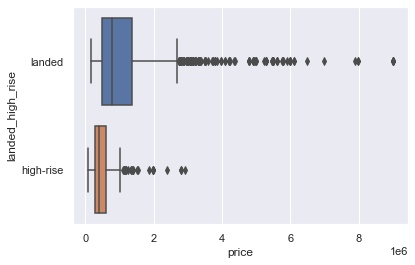

In [374]:
sns.boxplot(data = df, y='landed_high_rise', x = 'price', orient='h')

It's reasonable that landed's property prices are higher than high-rise in Selangor

### Will property's tenure affect the property price?

In [375]:
df['tenure'].value_counts()

Freehold               1834
Leasehold               672
Malay Reserved Land      28
99-year Leasehold        22
Bumi Lot                 13
Name: tenure, dtype: int64

In [376]:
df.groupby('tenure')['price'].agg(['mean','median','min','max']).round(2)

,mean,median,min,max
tenure,,,,
99-year Leasehold,"715,364","769,000","525,000","850,000"
Bumi Lot,"983,953","388,500","300,000","3,000,000"
Freehold,"943,433","650,000","88,000","7,980,000"
Leasehold,"1,083,463","676,500","95,000","9,000,000"
Malay Reserved Land,"548,204","405,000","270,000","1,500,000"


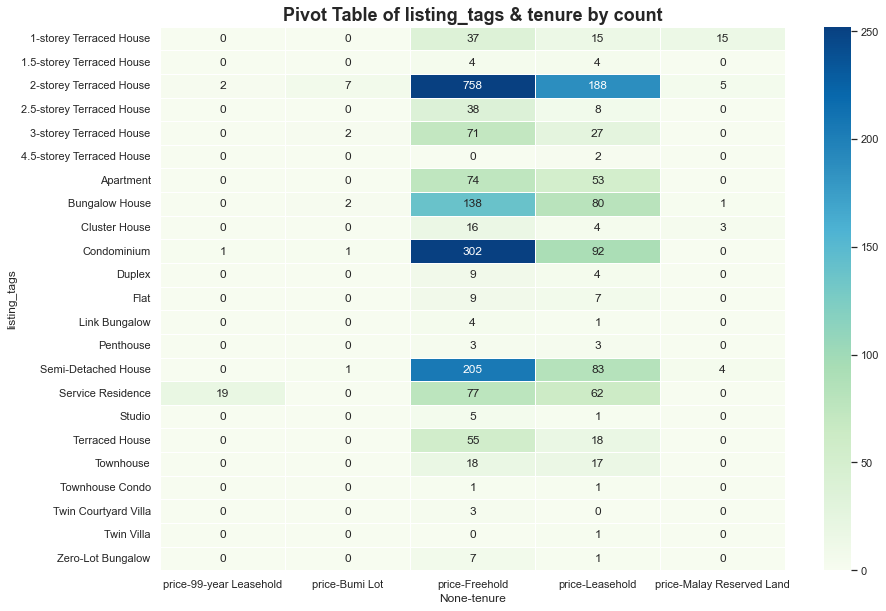

In [377]:
pivot_table_plot('listing_tags','tenure')

### Will the district/ location of the property affects the property price?

In [378]:
df['district'].value_counts()

Shah Alam         338
Kajang            228
Petaling Jaya     227
Puchong           175
Klang             168
Subang Jaya       161
Ampang            155
Damansara         148
Rawang            124
Cheras            116
Sepang            116
Cyberjaya         113
Bangi             108
Semenyih           89
Seri Kembangan     79
Sungai Buloh       68
Kuala Langat       40
Gombak             37
Kuala Selangor     22
Subang             13
Putrajaya          10
Hulu Selangor      10
Nilai               7
Ulu Klang           7
Hulu Langat         3
Beranang            3
Hulu Kelang         2
Sabak Bernam        2
Name: district, dtype: int64

Since like there is a mixture of district and area in the feature, let's us regroup the area into district.

In [379]:
df_district = pd.read_html(
    'https://en.wikipedia.org/wiki/Selangor#:~:text=Selangor%20is%20divided%20into%209,Langat%2C%20Hulu%20Langat%20and%20Sepang.'
)[8]

In [380]:
df_district = df_district[['Name','Sub-districts']]
df_district

,Name,Sub-districts
0,Gombak,"Ulu Klang, Ampang, Setapak, Batu Caves, Selaya..."
1,Hulu Langat,"Kajang, Beranang, Cheras, Hulu Langat, Hulu Se..."
2,Hulu Selangor,"Kuala Kubu Bharu, Sungai Chick, Ulu Yam, Ulu Y..."
3,Klang,"Klang, Kapar, Bukit Raja, Port Klang, Pandamar..."
4,Kuala Langat,"Bandar Saujana Putra, Jenjarom, Kanchong Darat..."
5,Kuala Selangor,"Api-api, Kuala Selangor, Bukit Melawati, Ijok,..."
6,Petaling,"Petaling Jaya, Subang Jaya, Shah Alam, Damansa..."
7,Sabak Bernam,"Sabak, Sungai Besar, Sekinchan."
8,Sepang,"Puchong, Bukit Puchong 2, 16 Sierra, Taman Put..."


In [381]:
import json

district_dict = {}

for i, row in df_district.iterrows():
    district_dict[row['Name'].lower()] = row['Sub-districts'].lower().split(', ')
    
district_dict.keys()

dict_keys(['gombak', 'hulu langat', 'hulu selangor', 'klang', 'kuala langat', 'kuala selangor', 'petaling', 'sabak bernam', 'sepang'])

In [382]:
area_dict = {}

for i, row in df_district.iterrows():
    for area in row['Sub-districts'].lower().split(', '):
        area_dict[area] = row['Name'].lower()
    
area_dict['bangi'] = 'hulu langat'
area_dict['semenyih'] = 'hulu langat'
area_dict['seri kembangan'] = 'petaling'
area_dict['subang'] = 'petaling'
area_dict['hulu kelang'] = 'gombak'

In [383]:
df['area'] = df['district'].copy()

In [384]:
df['district_enc'] = df['district'].str.lower()

In [385]:
# first of all, let us find all the values in 'district' which is really the district name
for i, row in df.iterrows():
    if row['district_enc'] in list(district_dict.keys()):
        pass
    else:
        try:
            df.loc[i,'district_enc'] = area_dict[row['district_enc']]
        except:
            df.loc[i,'district_enc'] = np.nan

In [386]:
# drop all the rows where the district is not under Selangor

starting_counts = df.shape[0]
na_counts = df['district_enc'].isna().sum()

df = df.dropna(axis = 0, how = 'any',subset = 'district_enc')

assert (starting_counts - df.shape[0]) == na_counts

In [387]:
df = df.drop(columns = ['area','district'])

In [388]:
# We can explore the price of property for different district

In [389]:
df['district_enc'].value_counts()

petaling          966
hulu langat       544
sepang            407
gombak            393
klang             168
kuala langat       40
kuala selangor     22
hulu selangor      10
sabak bernam        2
Name: district_enc, dtype: int64

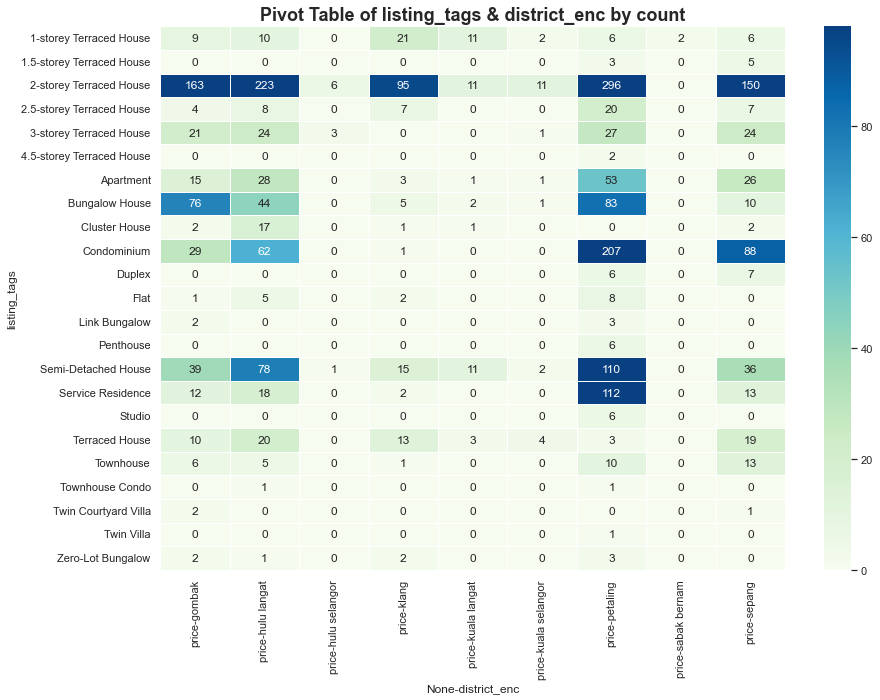

In [390]:
pivot_table_plot('listing_tags','district_enc')

In [391]:
pd.pivot_table(data = df[['district_enc','landed_high_rise','price']],
               index = 'district_enc', columns = 'landed_high_rise', aggfunc='mean', fill_value=0)

price          
landed_high_rise high-rise    landed
district_enc                        
gombak             391,918 1,457,995
hulu langat        350,777   969,288
hulu selangor            0   502,640
klang              281,000   735,204
kuala langat       320,000   831,359
kuala selangor     255,000   810,190
petaling           556,617 1,477,276
sabak bernam             0   300,000
sepang             403,692   860,688

1. Gombak & Petalling district having higher average price than the other district.
2. The number of property is also higher in the two district.
3. We can see that the landed property is more than high-rise property in every district.

### Will the availability of facilities affects the property price?

In [392]:
df.groupby('pool')['price'].agg(['mean','median'])

,mean,median
pool,,
False,"986,340","680,000"
True,"961,585","600,000"


In [393]:
df.groupby('fitness')['price'].agg(['mean','median'])

,mean,median
fitness,,
False,"1,025,695","695,000"
True,"870,133","580,000"


The reason behind why the price of property with fitness center or pool is lower is because usually only high-rise property has these facilities. As shown previously, the price of high-rise property is lower than landed property.

To see the effect of having either pool or fitness more, we may filter out only the property which is high-rise.

In [394]:
pd.pivot_table(data = df[df.landed_high_rise == 'high-rise'], index = 'fitness', columns='pool', aggfunc='mean', fill_value=0)['price']

pool,False,True
fitness,,
False,"391,700","478,871"
True,"392,000","511,757"


We can see that the property having neither of the above facilities will has a lower price. This is because the property might be old.

In [395]:
pd.pivot_table(data = df, index = 'fitness', columns='pool', aggfunc='mean', fill_value=0)['price']

pool,False,True
fitness,,
False,"988,350","1,424,373"
True,"903,254","868,410"


We can see that having neither fitness center nor pool will has a higher price than the property having either fitness or pool or even both. But not that the average price for property with pool only is the highest as usually bungalows or expensive landed property will have private pool built in. The evidence are as shown below

In [396]:
df_branded_property = df.loc[(df.pool == True ) & (df.fitness == False)]
df_branded_property.groupby('landed_high_rise')['price'].agg(['mean','median'])

,mean,median
landed_high_rise,,
high-rise,"478,871","438,000"
landed,"2,047,781","1,570,000"


In [397]:
df_branded_property.groupby('listing_tags')['price'].agg(['mean','median']).sort_values(by = 'mean', ascending = False)

,mean,median
listing_tags,,
Bungalow House,"3,922,621","3,500,000"
Twin Villa,"2,288,000","2,288,000"
4.5-storey Terraced House,"2,280,000","2,280,000"
Zero-Lot Bungalow,"1,900,000","1,900,000"
Semi-Detached House,"1,807,222","1,800,000"
3-storey Terraced House,"1,328,143","1,190,000"
Terraced House,"1,269,714","1,150,000"
Townhouse,"1,250,000","1,450,000"
Duplex,"898,000","898,000"


In [398]:
df.groupby('balcony')['price'].agg(['mean','median'])

,mean,median
balcony,,
False,"932,216","630,000"
True,"1,099,586","715,000"


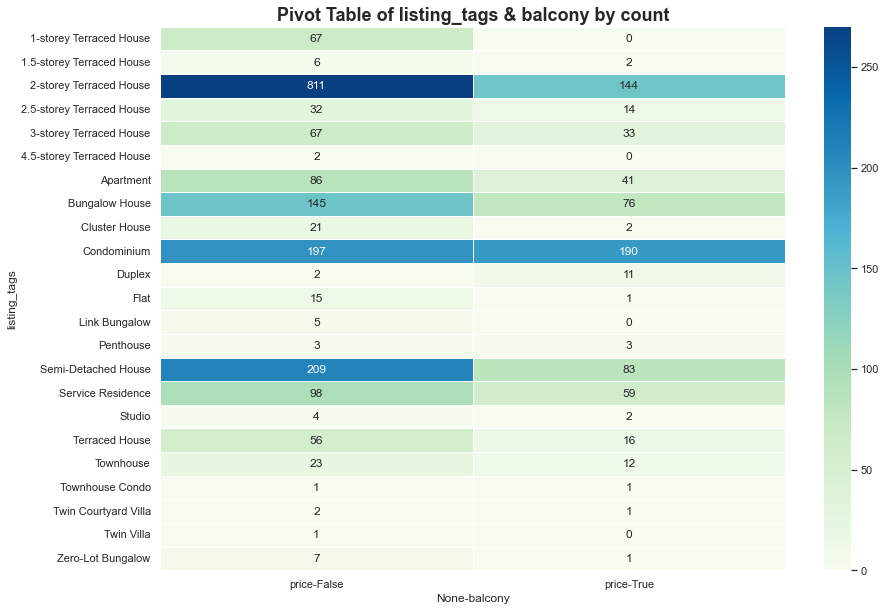

In [399]:
pivot_table_plot('listing_tags', 'balcony')

In [400]:
df.groupby(['landed_high_rise','balcony'])['price'].agg(['mean','median'])

mean    median
landed_high_rise balcony                    
high-rise        False     440,466   385,000
                 True      527,816   448,800
landed           False   1,069,095   710,000
                 True    1,555,516 1,200,000

### Let us see is there any correlation left between the features

<AxesSubplot:>

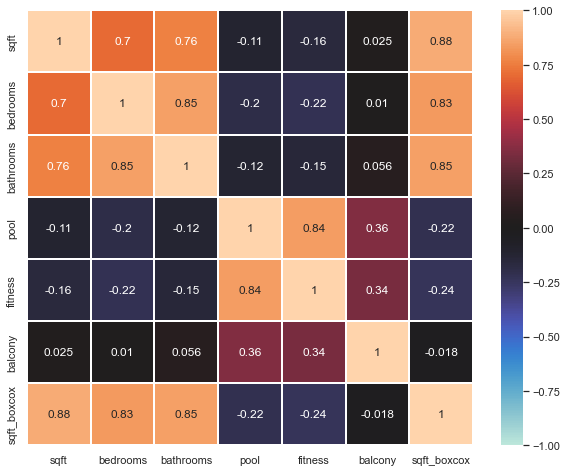

In [401]:
fig, ax = plt.subplots(figsize = (10,8))

sns.heatmap(df.drop(columns = ['price', 'log_price']).corr(), annot=True, linewidths=2, center=0, vmax=1, vmin = -1)

In [402]:
df.reset_index().to_csv('data/Cleaned_data_for_modelling.csv', index=False)